# Start of the lab 03
#### By Haeffner Edwin and Junod Arthur

## Concatenation of the two dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

mice_eeg1 = pd.read_csv('./data/EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('./data/EEG_mouse_data_2.csv')

mice_eeg = pd.concat([mice_eeg1, mice_eeg2], axis=0)
mice_eeg = np.array(mice_eeg)



In [2]:
# Get predicted classes
mice_eeg_classes = mice_eeg

import numpy as np

unique_chars, char_counts = np.unique(mice_eeg_classes[:, 0], return_counts=True)

for char, count in zip(unique_chars, char_counts):
    print(f"The character '{char}' appears {count} times.")

The character 'n' appears 13664 times.
The character 'r' appears 2839 times.
The character 'w' appears 24360 times.


## KFold grouping

In [3]:
from keras import layers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras

scaler = StandardScaler()

#normalize data
input_data = mice_eeg[:,1:26]
input_data = input_data.astype('float32')

output_data = mice_eeg[:,0:1]

output_data[output_data == 'w'] = 2.
output_data[output_data == 'n'] = 1.
output_data[output_data == 'r'] = 0.

output_data = output_data.astype('float32')

pl.clf()

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(mice_eeg)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


Fold 0:
  Train: index=[    0     2     3 ... 40860 40861 40862]
  Test:  index=[    1     8    15 ... 40854 40856 40857]
Fold 1:
  Train: index=[    0     1     4 ... 40859 40860 40862]
  Test:  index=[    2     3     5 ... 40855 40858 40861]
Fold 2:
  Train: index=[    1     2     3 ... 40857 40858 40861]
  Test:  index=[    0     4     6 ... 40859 40860 40862]


<Figure size 640x480 with 0 Axes>

## Data normalization

In [4]:
from keras import regularizers

def create_model():
    mlp = keras.Sequential([
        layers.Input(shape=(25,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(3)
    ])

    mlp.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
    )


    return mlp

mlp = create_model()
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,987 (7.76 KB)

 Trainable params: 1,987 (7.76 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from sklearn.preprocessing import LabelEncoder

history_list = []
trained_mlp = []
history = []

mice_eeg = np.array(mice_eeg)


for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    scaler = StandardScaler()
    # We need to create a new model everytime otherwise fit will continue previous training
    mlp = create_model()
    
    history = mlp.fit(
        x=scaler.fit_transform(input_data[train_index]), y=output_data[train_index],
        validation_data=(scaler.transform(input_data[test_index]), output_data[test_index]),
        epochs=100
    )

    history_list.append(history)
    trained_mlp.append(mlp)


Epoch 1/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - accuracy: 0.8016 - loss: 0.5349 - val_accuracy: 0.8767 - val_loss: 0.3430
Epoch 2/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.8757 - loss: 0.3481 - val_accuracy: 0.8791 - val_loss: 0.3303
Epoch 3/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.8796 - loss: 0.3326 - val_accuracy: 0.8800 - val_loss: 0.3266
Epoch 4/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.8821 - loss: 0.3257 - val_accuracy: 0.8813 - val_loss: 0.3248
Epoch 5/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.8830 - loss: 0.3213 - val_accuracy: 0.8810 - val_loss: 0.3238
Epoch 6/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.8834 - loss: 0.3185 - val_accuracy: 0.8808 - val_loss: 0.3236
Epoch 7/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.8838 - loss: 0.3162 - val_accuracy: 0.8806 - val_loss: 0.3235
Epoch 8/100
852/852 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.8844 - loss: 0

## Plotting the training history

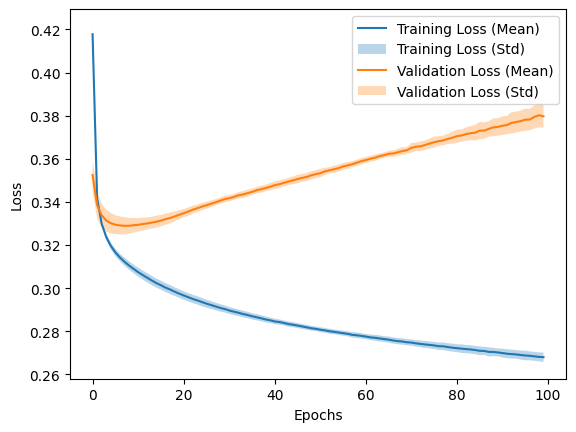

In [6]:
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step


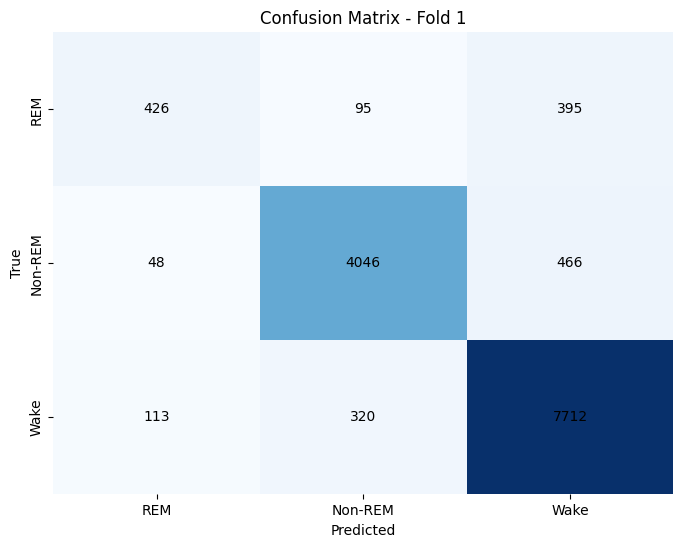

F1 Score - Fold 1: 0.7954942444509099
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


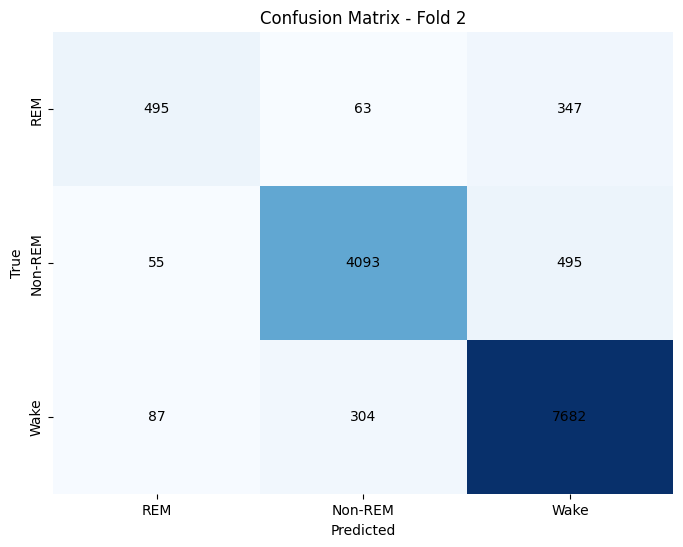

F1 Score - Fold 2: 0.8223322635925401
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


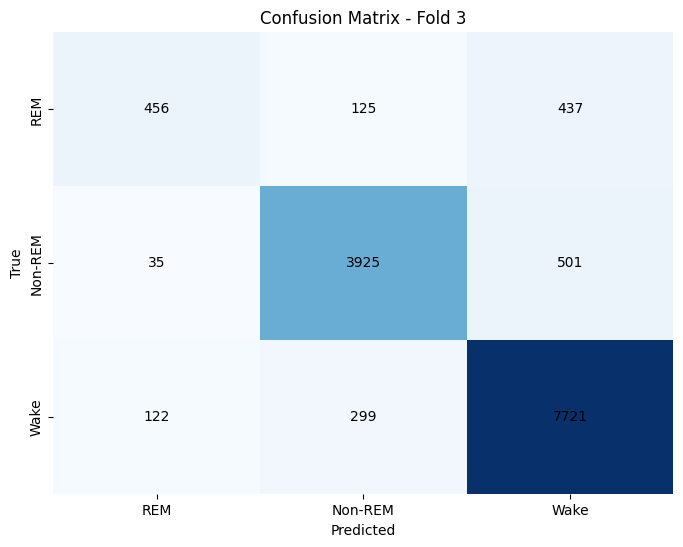

F1 Score - Fold 3: 0.7897703434979545


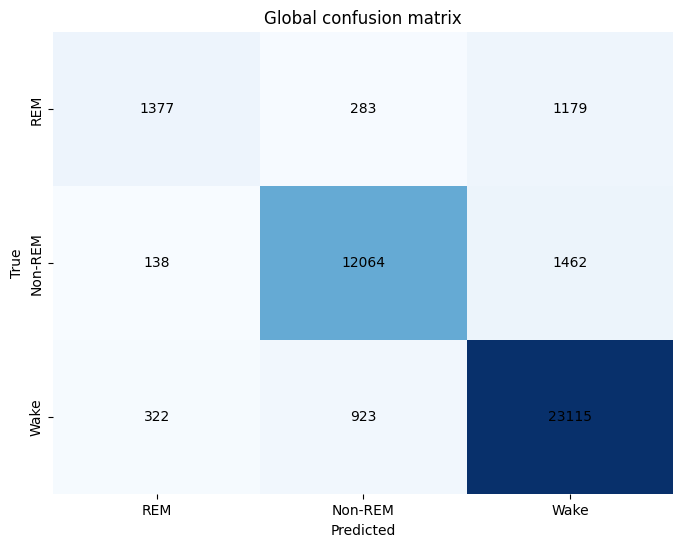

Mean F1 Score across all folds: 0.8025322838471348


In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns


def plot_confusion_matrix(confusion_matrix, title, class_labels):
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=False, fmt='', cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)

    # Add numerical values to the heatmap
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")

    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()

class_labels = ["REM", "Non-REM", "Wake"]

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
    # Evaluate the trained model on the test fold
    predictions = trained_mlp[i].predict(scaler.transform(input_data[test_index]))
    true_labels = output_data[test_index]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions.argmax(axis=1))
    mean_confusion_matrix += cm

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}', class_labels)

    # Compute F1 score
    f1 = f1_score(true_labels, predictions.argmax(axis=1), average='macro')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix.astype(int), 'Global confusion matrix', class_labels)

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

Get the model with the best f-score
for

In [8]:
# Find the model with the highest F1 score
best_score = -float('inf')
index = 0
i = 0

for score in f1_scores:

    if score > best_score:
        best_score = score
        index = i

    i += 1

best_model = f1_scores[index]
best_mlp = trained_mlp[index]

print(f"Best F1 Score: {best_score}")

Best F1 Score: 0.8223322635925401


In [9]:
test = pd.read_csv('./data/EEG_mouse_data_test.csv')
test_smol = test.iloc[:,0:25]
test_scaled = scaler.fit_transform(test_smol)

In [10]:
y_pred = best_mlp.predict(test_scaled)

2504/2504 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step


REM: 2995
Non-REM: 27263
Wake: 49851


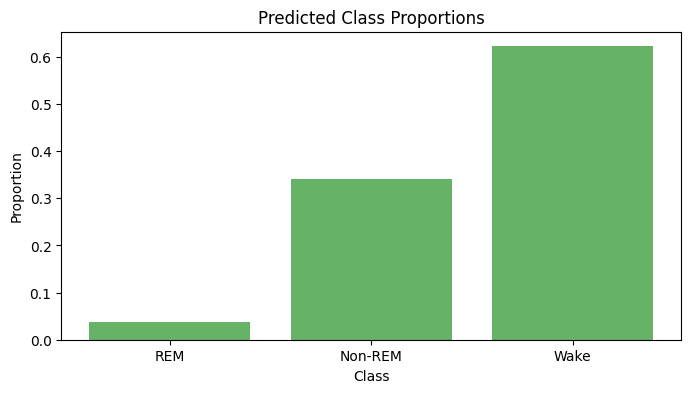

In [11]:
# Convert logits to probabilities
import numpy as np
y_pred_probs = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)

# Get predicted classes
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Count occurrences of each class
unique_counts = np.bincount(y_pred_classes)

# Compute class proportions
total_samples = len(y_pred_classes)
class_proportions = unique_counts / total_samples

# Map numerical values to class labels
class_labels = ["REM", "Non-REM", "Wake"]

# Visualisation
import matplotlib.pyplot as plt

for i, count in enumerate(unique_counts):
    print(f"{class_labels[i]}: {count}")

plt.figure(figsize=(8, 4))
plt.bar(range(len(class_proportions)), class_proportions, tick_label=class_labels, color='green', alpha=0.6)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Predicted Class Proportions')
plt.show()

## Output our prediction in a npy file

In [12]:
output_array = []  
for value in y_pred_classes:
    if value == 2:
        output_array.append('w')
    elif value == 1:
        output_array.append('n')
    elif value == 0:
        output_array.append('r')

with open('test_pred.npy', 'wb') as f:
    np.save(f, output_array)